# 2. Introductory chain data analysis 

## Setup

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import bin.params as p
import bin.utils as u

In [112]:
sns.set_style()
sns.set(rc={'figure.figsize':(12, 8)})

In [113]:
sasa_al_H_df = pd.read_csv(f'{p.DATA_DIR}/csv/sasa_aligned/sasa_H.csv', index_col=0)
sasa_al_L_df = pd.read_csv(f'{p.DATA_DIR}/csv/sasa_aligned/sasa_L.csv', index_col=0)

In [114]:
sasa_al_H_df.head(n=3)

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,143A,144,145,146,147,148,149
12E8:H,100.0,36.0,50.1,4.4,51.9,3.5,28.8,NaN,68.3,71.2,...,28.5,13.3,1.4,NaN,30.0,2.2,19.3,4.3,14.3,75.0
15C8:H,100.0,23.3,51.7,4.5,54.8,5.1,27.2,NaN,65.8,80.3,...,51.2,12.0,2.5,NaN,46.4,4.6,26.7,7.4,18.3,61.4
1A0Q:H,NaN,47.9,55.5,8.2,49.6,4.1,28.4,NaN,64.3,21.9,...,65.1,17.3,2.5,NaN,18.4,2.5,11.7,5.1,22.5,65.3


In [115]:
sasa_al_L_df.head(n=3)

,1,2,3,4,5,6,7,8,9,10,...,140,141,142,143,144,145,146,147,148,149
12E8:L,82.1,6.0,58.1,4.6,46.3,4.0,70.0,51.8,56.7,41.9,...,1.5,43.9,14.6,1.0,39.2,3.4,9.0,26.7,55.3,29.9
15C8:L,73.7,2.1,56.3,7.6,54.9,9.3,50.0,38.1,64.1,38.6,...,3.5,82.4,6.1,0.0,44.5,2.4,2.9,15.8,47.7,26.2
1A0Q:L,NaN,27.3,64.2,10.8,64.3,12.8,49.7,33.6,63.7,60.7,...,3.9,58.6,2.2,0.9,50.2,6.3,19.2,0.0,41.4,28.1


In [116]:
# Functions used throughout this notebook
# We put them together at one place so reading through the plot and data views more convenient
#   and there is no need to read long code blocks.
def show_only_nth_ticklabel(plot, n=3):
    for i, t in enumerate(plot.get_xticklabels()):
        if (i % n) != 0:
            t.set_visible(False)
            
def heatmap(data, title):
    plt.figure(figsize = (16, 1))
    final_data = data.to_frame().transpose()
    return sns.heatmap(final_data, vmax=100).set_title(title)  
    
def plot_heatmap(sasa: pd.DataFrame, metadata: pd.DataFrame, shorter: bool, title: str = ''):
    fine_sasa = pd.concat([sasa, metadata], axis=1, join='inner')
    columns = list(sasa.columns)
    
    selector = None
    if shorter:
        selector = fine_sasa.unaligned_len < 200
    else:
        selector = fine_sasa.unaligned_len > 200
        
    sums = fine_sasa[columns][selector].mean(axis=0)
    heatmap(sums, title)

def plot_differences(sasa: pd.DataFrame, metadata: pd.DataFrame, title: str = ''):
    fine_sasa = pd.concat([sasa, metadata], axis=1, join='inner')
    columns = list(sasa.columns)
    
    means_shorter = fine_sasa[columns][fine_sasa.unaligned_len < 200].mean(axis=0)
    means_longer = fine_sasa[columns][fine_sasa.unaligned_len > 200].mean(axis=0)
    for index, value in means_shorter.iteritems():
        if pd.isna(means_shorter[index]) or pd.isna(means_longer[index]):
            means_shorter[index] = means_longer[index] = 0
            
    differences = abs(means_shorter - means_longer)
    heatmap(differences, title)
    
def align_sasa(fasta: pd.DataFrame, unaligned_sasa: pd.DataFrame):
    aligned_sasa_chain = dict()
    for row_index, row in fasta.iterrows():
        new_row = []
        sasa_row = iter(unaligned_sasa.loc[row_index].dropna())
        try:
            for aa_index, aa in row.iteritems():
                if aa == '-': 
                    new_row.append(np.nan)
                else:
                    new_row.append(next(sasa_row))
        except StopIteration:
            pass

        aligned_sasa_chain[row_index] = new_row
    return aligned_sasa_chain

---

# RSA distributions per position

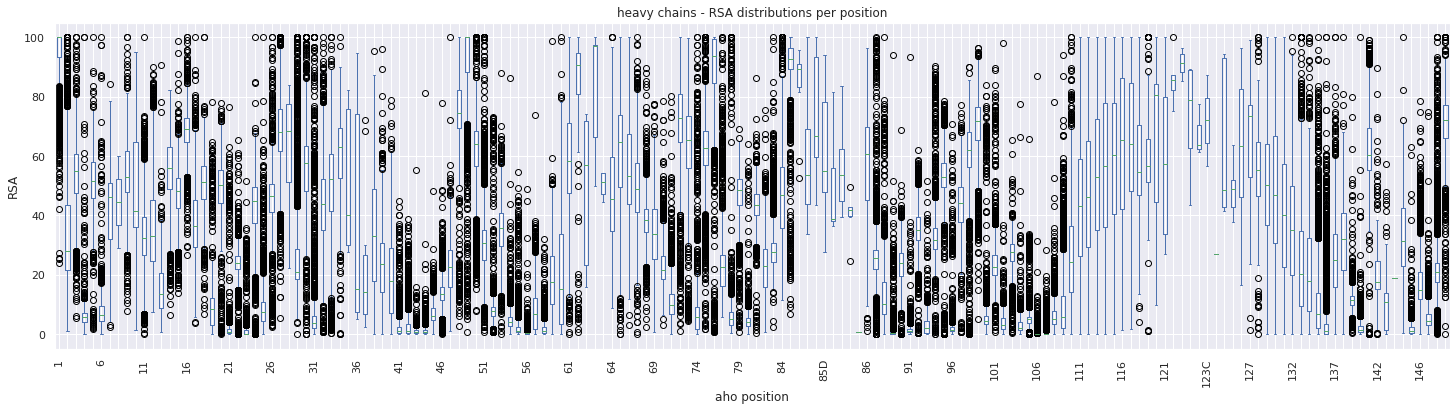

In [117]:
per_pos_dist_h_plot = sasa_al_H_df.plot.box(figsize=(25, 6))
_=u.annotate_plot(per_pos_dist_h_plot, x_rotation = 90, 
                  title='heavy chains - RSA distributions per position',
                  ylabel='RSA',
                  xlabel=f'{p.FINAL_NUMBERING_SCHEME} position', 
                  clean_ax_settings=dict(ax='x', nth_label_only=5))

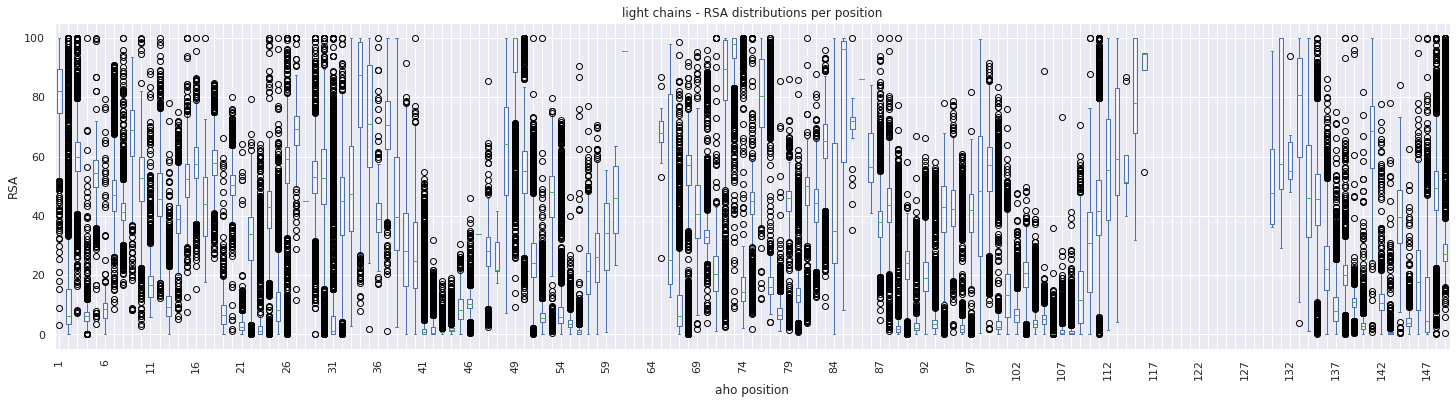

In [118]:
per_pos_dist_l_plot = sasa_al_L_df.plot.box(figsize=(25, 6))
_=u.annotate_plot(per_pos_dist_l_plot, x_rotation = 90, 
                  title='light chains - RSA distributions per position',
                  ylabel='RSA',
                  xlabel=f'{p.FINAL_NUMBERING_SCHEME} position', 
                  clean_ax_settings=dict(ax='x', nth_label_only=5))

---

## Missing values per position

In [119]:
nans_H_df = len(sasa_al_H_df) - sasa_al_H_df.count(axis=0).to_frame(name='nan_count')
nans_H_df['nan_count_perc'] = nans_H_df['nan_count'] / len(sasa_al_H_df) * 100
nans_H_df.head(n=2)

,nan_count,nan_count_perc
1,664,20.206939
2,123,3.743153


In [120]:
nans_L_df = len(sasa_al_L_df) - sasa_al_L_df.count(axis=0).to_frame(name='nan_count')
nans_L_df['nan_count_perc'] = nans_L_df['nan_count'] / len(sasa_al_L_df) * 100
nans_L_df.head(n=2)

,nan_count,nan_count_perc
1,622,18.928789
2,213,6.482045


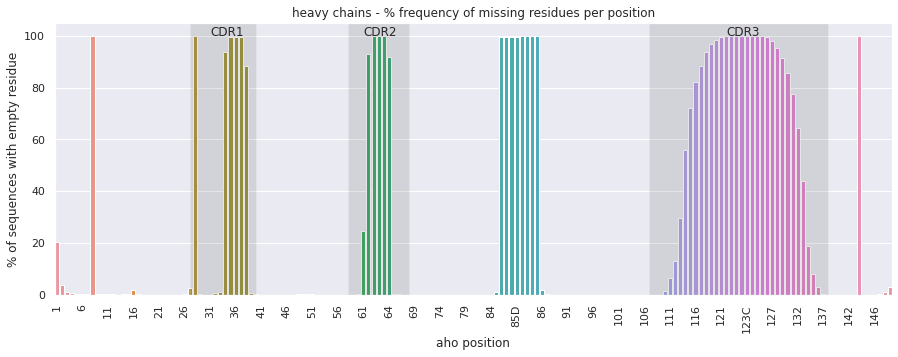

In [121]:
plt.figure(figsize = (15,5))
nans_H_plot = sns.barplot(x=nans_H_df.index, y=nans_H_df['nan_count_perc'])
_=u.annotate_plot(nans_H_plot, x_rotation = 90, 
                  title='heavy chains - % frequency of missing residues per position',
                  ylabel='% of sequences with empty residue',
                  xlabel=f'{p.FINAL_NUMBERING_SCHEME} position', 
                  clean_ax_settings=dict(ax='x', nth_label_only=5))
nans_H_plot.margins(x=0)
u.show_cdr_regions(list(nans_H_df.index), nans_H_plot, 'H', 
                   p.FINAL_NUMBERING_SCHEME, cdr_label_coord=100, position_ax='x',
                   text_offsets=[4, 3, 15])

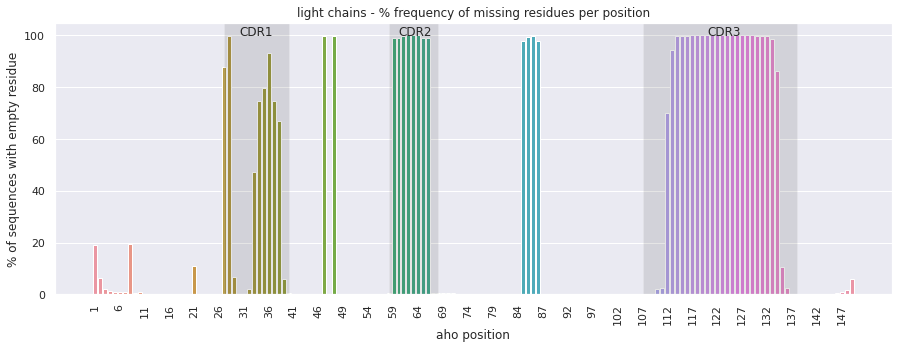

In [122]:
plt.figure(figsize = (15,5))
nans_L_plot = sns.barplot(x=nans_L_df.index, y=nans_L_df['nan_count_perc'])
_=u.annotate_plot(nans_L_plot, x_rotation = 90, 
                  title='light chains - % frequency of missing residues per position',
                  ylabel='% of sequences with empty residue',
                  xlabel=f'{p.FINAL_NUMBERING_SCHEME} position', 
                  clean_ax_settings=dict(ax='x', nth_label_only=5))
u.show_cdr_regions(list(nans_L_df.index), nans_L_plot, 'L', 
                   p.FINAL_NUMBERING_SCHEME, cdr_label_coord=100, position_ax='x',
                   text_offsets=[3, 2, 13])

**Number of completely empty positions:**

In [106]:
(nans_H_df['nan_count'] == len(sasa_al_H_df)).sum()

0

In [107]:
(nans_L_df['nan_count'] == len(sasa_al_L_df)).sum()

16

---

## RSA Clustermaps

In [123]:
NAN = 100

/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


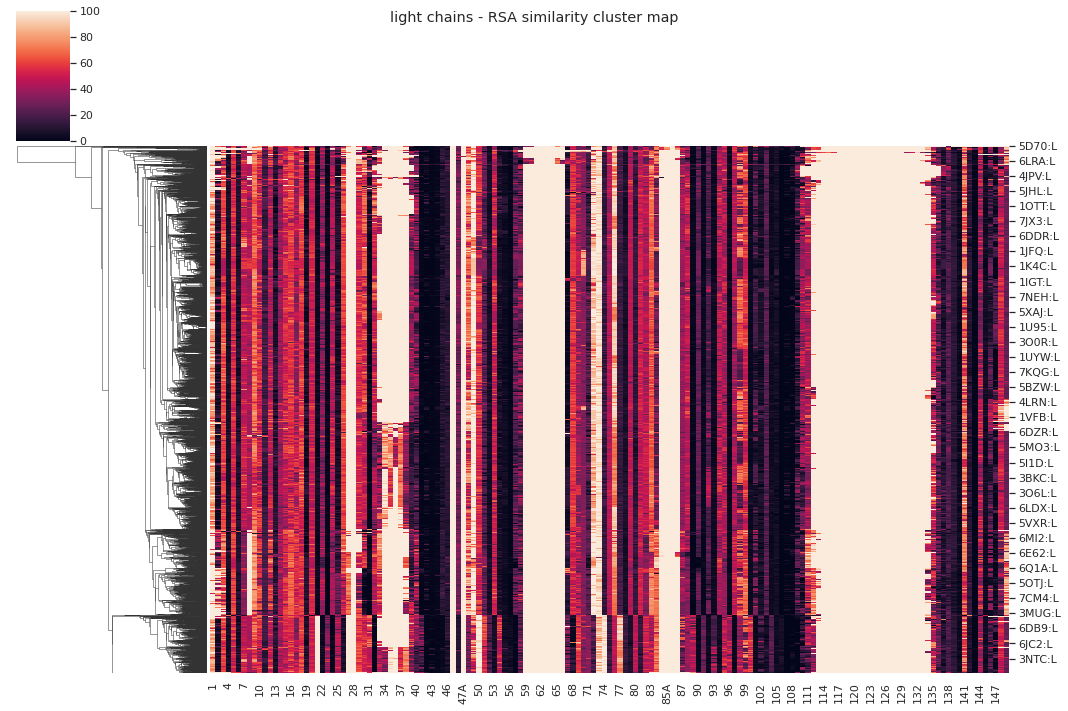

In [124]:
l_pos_clustermap = sns.clustermap(sasa_al_L_df.replace(np.nan, NAN), 
                                  col_cluster=False, vmax=100,
                                  figsize=(15, 10))
l_pos_clustermap.fig.suptitle(
    'light chains - RSA similarity cluster map'
)
# TODO labely do clustermapu?
l_pos_clustermap.fig.savefig(f'{p.DATA_DIR}/png/light_chain_clustermap_nan{NAN}.png')

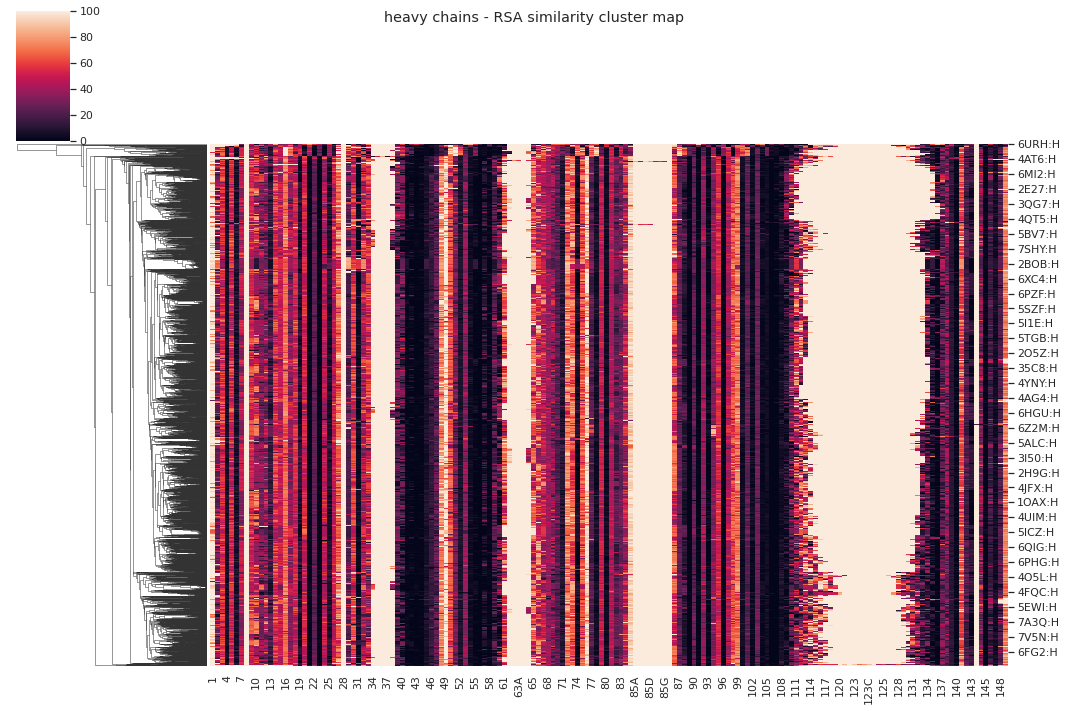

In [125]:
h_pos_clustermap = sns.clustermap(sasa_al_H_df.replace(np.nan, NAN), 
                                  col_cluster=False, vmax=100,
                                  figsize=(15, 10))
h_pos_clustermap.fig.suptitle(
    'heavy chains - RSA similarity cluster map'
)
# TODO labely do clustermapu?
h_pos_clustermap.fig.savefig(f'{p.DATA_DIR}/png/heavy_chain_clustermap_nan{NAN}.png')

### Annotate aligned SASA with FASTA metadata

The reason is to be able to use these in the subsequent analysis.

Right now, we will be using only `UNALIGNED_LEN` metadata column.

In [320]:
h = pd.concat([aligned_sasa['H'], metadata_dfs['H']], axis=1, join='inner')
l = pd.concat([aligned_sasa['L'], metadata_dfs['L']], axis=1, join='inner')

h.head()

,1,2,3,4,5,6,7,8,9,10,...,e-value,score,seqstart_index,seqend_index,identity_species,v_gene,v_identity,j_gene,j_identity,unaligned_len
12E8:H,100.0,36.0,50.1,4.4,51.9,3.5,28.8,100.0,68.3,71.2,...,1.100000e-53,171.7,0,119,NaN,NaN,0.0,NaN,0.0,221
15C8:H,100.0,23.3,51.7,4.5,54.8,5.1,27.2,100.0,65.8,80.3,...,2.100000e-55,177.3,0,118,NaN,NaN,0.0,NaN,0.0,217
1A0Q:H,100.0,47.9,55.5,8.2,49.6,4.1,28.4,100.0,64.3,21.9,...,4.300000e-55,176.3,0,113,NaN,NaN,0.0,NaN,0.0,205
1A14:H,93.5,18.7,42.7,6.8,44.8,15.7,32.0,100.0,61.0,66.3,...,7.500000e-58,185.2,0,119,NaN,NaN,0.0,NaN,0.0,120
1A2Y:H,93.7,24.6,51.8,7.1,65.6,12.4,57.4,100.0,48.9,48.9,...,5.500000e-55,175.9,0,115,NaN,NaN,0.0,NaN,0.0,116


In [321]:
l.head()

,1,2,3,4,5,6,7,8,9,10,...,e-value,score,seqstart_index,seqend_index,identity_species,v_gene,v_identity,j_gene,j_identity,unaligned_len
12E8:L,82.1,6.0,58.1,4.6,46.3,4.0,70.0,51.8,56.7,41.9,...,3.400000e-53,170.2,0,107,NaN,NaN,0.0,NaN,0.0,214
15C8:L,73.7,2.1,56.3,7.6,54.9,9.3,50.0,38.1,64.1,38.6,...,4.700000e-56,179.5,0,108,NaN,NaN,0.0,NaN,0.0,213
1A0Q:L,100.0,27.3,64.2,10.8,64.3,12.8,49.7,33.6,63.7,60.7,...,3.900000e-47,150.6,0,105,NaN,NaN,0.0,NaN,0.0,211
1A14:L,88.6,2.2,65.7,5.5,44.0,7.8,43.5,49.8,75.7,64.3,...,8.100000e-48,152.8,0,101,NaN,NaN,0.0,NaN,0.0,104
1A2Y:L,74.1,22.6,58.7,8.4,67.2,11.9,47.3,40.3,76.3,52.7,...,6.200000e-52,166.1,0,106,NaN,NaN,0.0,NaN,0.0,107


## Per-position heatmaps

#### Mean SASA per position (short sequences vs. long sequences)

The threshold to distinguish between sequence being SHORT or LONG is **200** aminoacids right now.

Light chain:

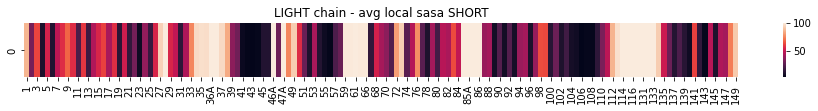

In [322]:
plot_heatmap(sasa=aligned_sasa['L'], metadata=metadata_dfs['L'], 
             shorter=True, title='LIGHT chain - avg local sasa SHORT')

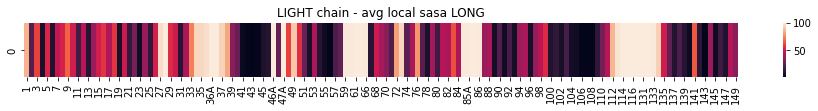

In [323]:
plot_heatmap(sasa=aligned_sasa['L'], metadata=metadata_dfs['L'],
             shorter=False, title='LIGHT chain - avg local sasa LONG')

Heavy chain:

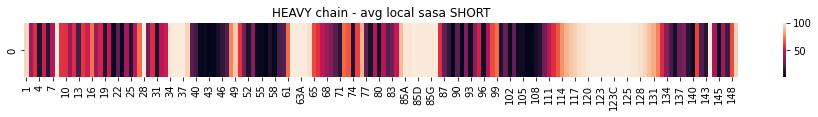

In [324]:
plot_heatmap(sasa=aligned_sasa['H'], metadata=metadata_dfs['H'],
             shorter=True, title='HEAVY chain - avg local sasa SHORT')

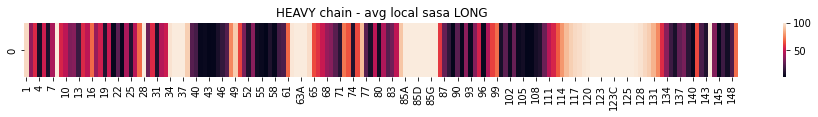

In [325]:
plot_heatmap(sasa=aligned_sasa['H'], metadata=metadata_dfs['H'],
             shorter=False, title='HEAVY chain - avg local sasa LONG')

#### Difference between LONG and SHORT means per position

So we identify positions where there is significant mean difference between LONG and SHORT sequences

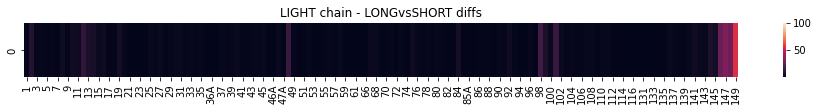

In [326]:
plot_differences(sasa=aligned_sasa['L'], metadata=metadata_dfs['L'],
                 title='LIGHT chain - LONGvsSHORT diffs')

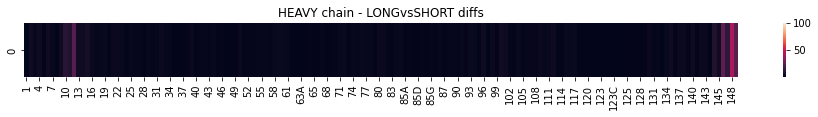

In [327]:
plot_differences(sasa=aligned_sasa['H'], metadata=metadata_dfs['H'], 
                 title='HEAVY chain - LONGvsSHORT diffs')